In [1]:
import os
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
import warnings
warnings.filterwarnings("ignore")

/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



In [2]:
# Choose the country and the year for validation
# Country code should be in ISO 3166-1 alpha-2 format which is 2 country code letters.
# For example, Germany is DE, France is FR, etc.
country_code = "US"
scenario_folder = "US"
year = 2020

### Functions

In [3]:
def load_ember_data():
    """
    Load the Ember data from a CSV file located in the data folder.

    Returns:
        pd.DataFrame: Ember data in long format.
    """
    ember_data_path = os.path.join(os.getcwd(), "../data/ember_yearly_full_release_long_format.csv")
    ember_data = pd.read_csv(ember_data_path)
    return ember_data

def get_network_path(scenario_folder):
    """
    Get the full path to the PyPSA network file from the specified scenario folder.
    Assumes that only one network file exists in the folder.

    Args:
        scenario_folder (str): Folder containing the scenario data.

    Returns:
        str: Full path to the network file.

    Raises:
        AssertionError: If more than one network file exists in the folder.
    """
    foldername = f"{scenario_folder}/networks"
    results_dir = os.path.join(os.getcwd(), f"../pypsa_data/results/{scenario_folder}/networks")
    filenames = os.listdir(results_dir)
    
    # Ensure only one network file exists
    assert len(filenames) == 1, print("Only 1 network per folder is allowed!")
    
    filepath = os.path.join(results_dir, filenames[0])
    return filepath

def create_results_dir():
    """
    Create a results directory if it does not already exist.
    This is where output data will be stored.
    """
    # Create the folder if it doesn't exist
    if not os.path.exists("../results"):
        os.makedirs("../results")

def convert_two_country_code_to_three(country_code):
    """
    Convert a two-letter country code to a three-letter ISO country code.

    Args:
        country_code (str): Two-letter country code (ISO 3166-1 alpha-2).

    Returns:
        str: Three-letter country code (ISO 3166-1 alpha-3).
    """
    country = pycountry.countries.get(alpha_2=country_code)
    return country.alpha_3

def load_pypsa_network(scenario_folder):
    """
    Load a PyPSA network from a specific scenario folder.

    Args:
        scenario_folder (str): Folder containing the scenario data.

    Returns:
        pypsa.Network: The loaded PyPSA network object.
    """
    network_path = get_network_path(scenario_folder)
    network = pypsa.Network(network_path)
    return network

def get_demand_ember(data, country_code, year):
    """
    Get the electricity demand for a given country and year from Ember data.

    Args:
        data (pd.DataFrame): Ember data.
        country_code (str): Country code (ISO 3166-1 alpha-2).
        year (int): Year of interest.

    Returns:
        float or None: Electricity demand if found, otherwise None.
    """
    demand = data[(data["Year"] == year) 
                  & (data["Country code"] == country_code) 
                  & (data["Category"] == "Electricity demand") 
                  & (data["Subcategory"] == "Demand")]["Value"]
    
    if len(demand) != 0:
        return demand.iloc[0]
    return None

def get_demand_pypsa(network):
    """
    Get the total electricity demand from the PyPSA network.

    Args:
        network (pypsa.Network): PyPSA network object.

    Returns:
        float: Total electricity demand in TWh.
    """
    demand_pypsa = network.loads_t.p_set.multiply(
        network.snapshot_weightings.objective, axis=0).sum().sum() / 1e6
    demand_pypsa = demand_pypsa.round(4)
    return demand_pypsa

def get_installed_capacity_ember(data, three_country_code, year):
    """
    Get installed capacity by fuel type for a given country and year from Ember data.

    Args:
        data (pd.DataFrame): Ember data.
        three_country_code (str): Country code (ISO 3166-1 alpha-3).
        year (int): Year of interest.

    Returns:
        pd.DataFrame: Installed capacity by fuel type.
    """
    capacity_ember = data[
        (data["Country code"] == three_country_code) 
        & (data["Year"] == year)
        & (data["Category"] == "Capacity") 
        & (data["Subcategory"] == "Fuel")][["Variable", "Value"]].reset_index(drop=True)
    
    # Drop irrelevant rows
    drop_row = ["Other Renewables"]
    capacity_ember = capacity_ember[~capacity_ember["Variable"].isin(drop_row)]

    # Standardize fuel types
    capacity_ember = capacity_ember.replace({
        "Gas": "Fossil fuels", 
        "Bioenergy": "Biomass", 
        "Coal": "Fossil fuels",
        "Other Fossil": "Fossil fuels"})
    
    capacity_ember = capacity_ember.groupby("Variable").sum()
    capacity_ember.columns = ["Ember data"]

    return capacity_ember

def get_installed_capacity_pypsa(network):
    """
    Get installed capacity by fuel type from the PyPSA network.

    Args:
        network (pypsa.Network): PyPSA network object.

    Returns:
        pd.DataFrame: Installed capacity by fuel type.
    """
    gen_capacities = network.generators.groupby("carrier").p_nom.sum()
    storage_capacities = network.storage_units.groupby("carrier").p_nom.sum()
    capacity_pypsa = (pd.concat([gen_capacities, storage_capacities], axis=0) / 1e3).round(2)

    # Define all possible carriers
    all_carriers = ["nuclear", "coal", "lignite", "CCGT", 
                    "OCGT", "hydro", "ror", "PHS", "solar", "offwind-ac", 
                    "offwind-dc", "onwind", "biomass"]
    
    # Reindex to include missing carriers
    capacity_pypsa = capacity_pypsa.reindex(all_carriers, fill_value=0)
    
    # Rename fuel types to match convention
    capacity_pypsa.rename(index={
        "nuclear":"Nuclear", 
        "solar":"Solar", 
        "biomass":"Biomass"}, inplace=True)
    
    # Aggregate fossil fuel and hydro capacities
    capacity_pypsa["Fossil fuels"] = capacity_pypsa[["coal", "lignite", "CCGT", "OCGT"]].sum()
    capacity_pypsa["Hydro"] = capacity_pypsa[["hydro", "ror"]].sum()
    capacity_pypsa["Wind"] = capacity_pypsa[["offwind-ac", "offwind-dc", "onwind"]].sum()
    
    # Filter and reformat
    capacity_pypsa = capacity_pypsa.loc[["Nuclear", "Fossil fuels", "Hydro", 
                                         "PHS", "Solar", "Wind", "Biomass"]]
    capacity_pypsa.name = "PyPSA data"
    capacity_pypsa = capacity_pypsa.to_frame()

    return capacity_pypsa

def get_generation_capacity_ember(data, three_country_code, year):
    """
    Get electricity generation by fuel type for a given country and year from Ember data.

    Args:
        data (pd.DataFrame): Ember data.
        three_country_code (str): Country code (ISO 3166-1 alpha-3).
        year (int): Year of interest.

    Returns:
        pd.DataFrame: Electricity generation by fuel type.
    """
    generation_ember = data[
        (data["Category"] == "Electricity generation")
        & (data["Country code"] == three_country_code)
        & (data["Year"] == year)
        & (data["Subcategory"] == "Fuel")
        & (data["Unit"] == "TWh")
            ][["Variable", "Value"]].reset_index(drop=True)

    # Drop irrelevant rows
    drop_row = ["Other Renewables"]
    generation_ember = generation_ember[~generation_ember["Variable"].isin(drop_row)]

    # Standardize fuel types
    generation_ember = generation_ember.replace({
        "Gas": "Fossil fuels", 
        "Bioenergy": "Biomass", 
        "Coal": "Fossil fuels",
        "Other Fossil": "Fossil fuels"})
    
    # Group by fuel type
    generation_ember = generation_ember.groupby("Variable").sum()
    generation_ember.loc["Load shedding"] = 0.0
    generation_ember.columns = ["Ember data"]

    return generation_ember

def get_generation_capacity_pypsa(network):
    """
    Get electricity generation by fuel type from the PyPSA network.

    Args:
        network (pypsa.Network): PyPSA network object.

    Returns:
        pd.DataFrame: Electricity generation by fuel type.
    """
    gen_capacities = (network.generators_t
                      .p.multiply(network.snapshot_weightings.objective, axis=0)
                      .groupby(network.generators.carrier, axis=1).sum().sum())
    
    storage_capacities = (network.storage_units_t
                          .p.multiply(network.snapshot_weightings.objective, axis=0)
                          .groupby(network.storage_units.carrier, axis=1).sum().sum())
    
    # Combine generator and storage generation capacities
    generation_pypsa = ((pd.concat([gen_capacities, storage_capacities], axis=0)) / 1e6).round(2)

    # Define all possible carriers
    all_carriers = ["nuclear", "coal", "lignite", "CCGT", "OCGT", 
                    "hydro", "ror", "PHS", "solar", "offwind-ac", 
                    "offwind-dc", "onwind", "biomass", "load"]
    
    # Reindex to include missing carriers
    generation_pypsa = generation_pypsa.reindex(all_carriers, fill_value=0)
    
    # Rename fuel types to match convention
    generation_pypsa.rename(index={
        "nuclear":"Nuclear", 
        "solar":"Solar", 
        "biomass":"Biomass", 
        "load":"Load shedding"}, inplace=True)
    
    # Aggregate fossil fuel, hydro, and wind generation
    generation_pypsa["Fossil fuels"] = generation_pypsa[["CCGT", "OCGT", "coal", "lignite"]].sum()
    generation_pypsa["Hydro"] = generation_pypsa[["hydro", "ror"]].sum()
    generation_pypsa["Wind"] = generation_pypsa[["offwind-ac", "offwind-dc", "onwind"]].sum()
    
    # Adjust load shedding value
    generation_pypsa["Load shedding"] /= 1e3
    
    # Filter and reformat
    generation_pypsa = generation_pypsa.loc[["Nuclear", "Fossil fuels", "PHS", 
                                             "Hydro", "Solar", "Wind", "Biomass", 
                                             "Load shedding"]]
    generation_pypsa.name = "PyPSA data"
    generation_pypsa = generation_pypsa.to_frame()

    return generation_pypsa

def get_country_name(country_code):
    """ Input:
            country_code - two letter code of the country
        Output:
            country.name - corresponding name of the country
            country.alpha_3 - three letter code of the country
    """
    try:
        country = pycountry.countries.get(alpha_2=country_code)
        return country.name, country.alpha_3 if country else None
    except KeyError:
        return None
    
def get_data_EIA(data_path, country_code, year):
    """
    Retrieves energy generation data from the EIA dataset for a specified country and year.

    Args:
        data_path (str): Path to the EIA CSV file.
        country_code (str): Two-letter or three-letter country code (ISO).
        year (int or str): Year for which energy data is requested.

    Returns:
        pd.DataFrame: DataFrame containing energy generation data for the given country and year, 
                    or None if no matching country is found.
    """

    # Load EIA data from CSV file
    data = pd.read_csv(data_path)
    
    # Rename the second column to 'country' for consistency
    data.rename(columns={"Unnamed: 1": "country"}, inplace=True)
    
    # Remove leading and trailing spaces in the 'country' column
    data["country"] = data["country"].str.strip()
    
    # Extract the three-letter country code from the 'API' column
    data["code_3"] = data.dropna(subset=["API"])["API"].apply(
        lambda x: x.split('-')[2] if isinstance(x, str) and len(x.split('-')) > 3 else x
    )
    
    # Get the official country name and three-letter country code using the provided two-letter code
    country_name, country_code3 = get_country_name(country_code)
    
    # Check if the three-letter country code exists in the dataset
    if country_code3 and country_code3 in data.code_3.unique():
        # Retrieve the generation data for the specified year
        result = data.query("code_3 == @country_code3")[["country", str(year)]]
    
    # If not found by code, search by the country name
    elif country_name and country_name in data.country.unique():
        # Find the country index and retrieve generation data
        country_index = data.query("country == @country_name").index[0]
        result = data.iloc[country_index+1:country_index+18][["country", str(year)]]
    
    else:
        # If no match is found, return None
        result = None

    # Convert the year column to float for numeric operations
    result[str(year)] = result[str(year)].astype(float)

    return result

def preprocess_eia_data(data):
    """
    Preprocesses the EIA energy data by renaming and filtering rows and columns.

    Args:
        data (pd.DataFrame): DataFrame containing EIA energy data.

    Returns:
        pd.DataFrame: Cleaned and preprocessed DataFrame ready for analysis.
    """
    
    # Strip the last 13 characters (descriptive text) from the 'country' column
    data["country"] = data["country"].apply(lambda x: x[:-13].strip())
    
    # Set 'country' as the index of the DataFrame
    data.set_index("country", inplace=True)
    
    # Rename columns to provide clarity
    data.columns = ["EIA Data"]
    
    # Rename specific rows to match more standard terms
    data.rename(index={"Hydroelectricity": "Hydro",
                       "Biomass and waste": "Biomass", 
                       "Hydroelectric pumped storage": "PHS"}, inplace=True)
    
    # Drop unwanted renewable energy categories
    data.drop(index=["Renewables", "Non-hydroelectric renewables", 
                     "Geothermal", "Solar, tide, wave, fuel cell", "Tide and wave"], inplace=True)
    
    # Filter the DataFrame to only include relevant energy sources
    data = data.loc[["Nuclear", "Fossil fuels", "Hydro", "PHS", "Solar", "Wind", "Biomass"], :]
    
    return data

### Load data

In [4]:
# Load Ember data
ember_data = load_ember_data()

# Load PyPSA network
# Note: you can also load the network directly using """network = pypsa.Network(network_path)"""
network = load_pypsa_network(scenario_folder)

# Load EIA data
EIA_demand_path = os.path.join(os.getcwd(), "../data", "EIA_demands.csv")
EIA_installed_capacities_path = os.path.join(os.getcwd(), "../data", "EIA_installed_capacities.csv")
EIA_generation_path = os.path.join(os.getcwd(), "../data", "EIA_electricity_generation.csv")

three_country_code = convert_two_country_code_to_three(country_code)
create_results_dir()

INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-24H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Demand

In [5]:
demand_ember = get_demand_ember(ember_data, three_country_code, year)
pypsa_demand = get_demand_pypsa(network)

EIA_demand = get_data_EIA(EIA_demand_path, country_code, year)
EIA_demand = EIA_demand.iloc[0,1]

In [6]:
print(f"Demand from Ember: {demand_ember} \nDemand from PyPSA: {pypsa_demand} \nDemand from EIA: {EIA_demand}")

Demand from Ember: 4090.49 
Demand from PyPSA: 3988.1865 
Demand from EIA: 3897.89940047


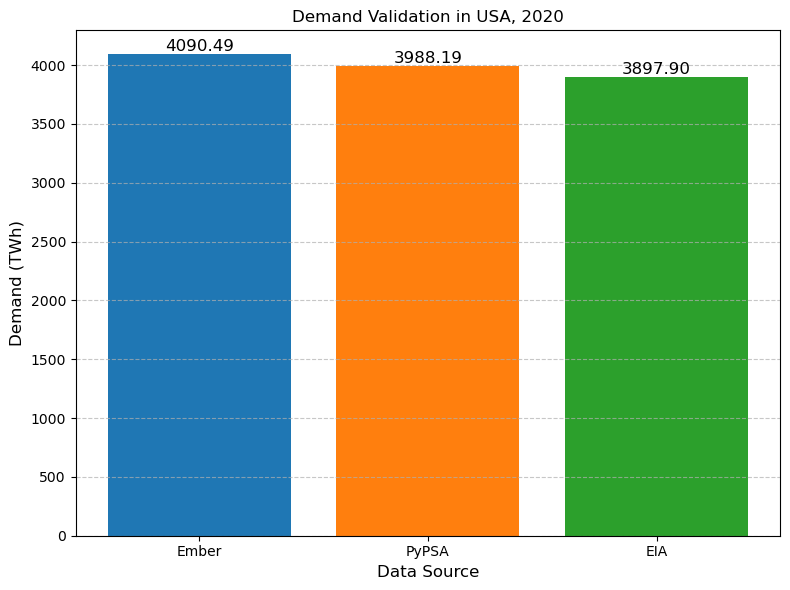

In [7]:
plt.figure(figsize=(8, 6))  # Set figure size
bars = plt.bar(["Ember", "PyPSA", "EIA"], [demand_ember, pypsa_demand, EIA_demand], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title(f"Demand Validation in {three_country_code}, {year}")
plt.ylabel("Demand (TWh)", fontsize=12)
plt.xlabel("Data Source", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.savefig(f"../results/demand_validation_ember_{country_code}.png")
plt.show()

### Installed Capacity

In [8]:
installed_capacity_ember = get_installed_capacity_ember(ember_data, three_country_code, year)
pypsa_capacity = get_installed_capacity_pypsa(network)

In [9]:
EIA_inst_capacities = get_data_EIA(EIA_installed_capacities_path, country_code, year)
EIA_inst_capacities = preprocess_eia_data(EIA_inst_capacities)

In [10]:
installed_capacity_df = pd.concat([installed_capacity_ember, pypsa_capacity, EIA_inst_capacities], axis=1).fillna(0)
installed_capacity_df

,Ember data,PyPSA data,EIA Data
Biomass,10.83,8.89,16.0291
Fossil fuels,786.94,783.52,731.2059
Hydro,83.83,79.82,79.9243
Nuclear,96.50,99.96,96.5006
Solar,76.44,60.32,75.6389
Wind,118.66,133.25,118.3787
PHS,0.00,22.01,23.0162


In [11]:
installed_capacity_df.sum()

Ember data    1173.2000
PyPSA data    1187.7700
EIA Data      1140.6937
dtype: float64

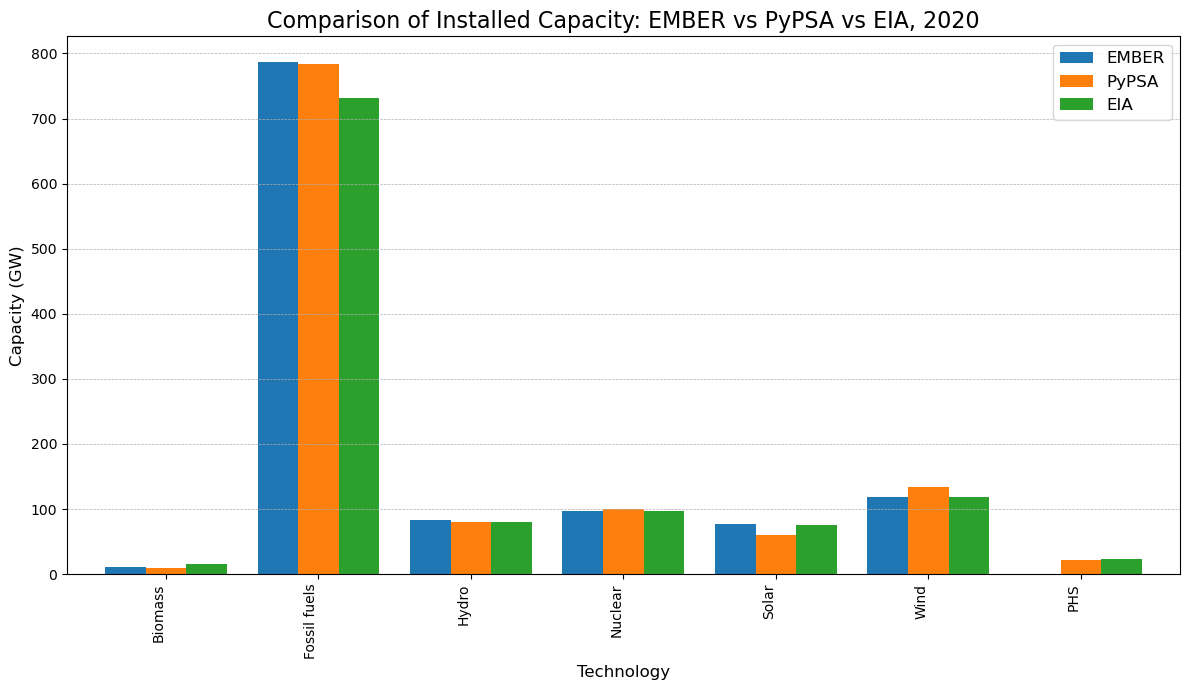

In [12]:
ax = installed_capacity_df.plot(kind="bar", figsize=(12, 7), width=0.8)
plt.title(f"Comparison of Installed Capacity: EMBER vs PyPSA vs EIA, {year}", fontsize=16)
plt.xlabel("Technology", fontsize=12)
plt.ylabel("Capacity (GW)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend(["EMBER", "PyPSA", "EIA"], loc="upper right", fontsize=12)
plt.tight_layout()
plt.savefig(f"../results/capacity_validation_ember_{country_code}.png")
plt.show()

### Generation

In [13]:
generation_data_ember = get_generation_capacity_ember(ember_data, three_country_code, year)
pypsa_generation = get_generation_capacity_pypsa(network)

In [14]:
EIA_generation = get_data_EIA(EIA_generation_path, country_code, year)
EIA_generation = preprocess_eia_data(EIA_generation)

In [15]:
generation_df = pd.concat([generation_data_ember, pypsa_generation, EIA_generation], axis=1).fillna(0)
generation_df

,Ember data,PyPSA data,EIA Data
Biomass,54.70,9.07,67.566802
Fossil fuels,2431.90,2057.89,2429.342031
Hydro,279.95,616.19,285.273895
Nuclear,789.88,875.65,789.878863
Solar,130.72,82.54,130.721095
Wind,337.94,312.77,337.938049
Load shedding,0.00,0.00,0.000000
PHS,0.00,0.00,-5.321205


In [16]:
generation_df.sum()

Ember data    4025.090000
PyPSA data    3954.110000
EIA Data      4035.399529
dtype: float64

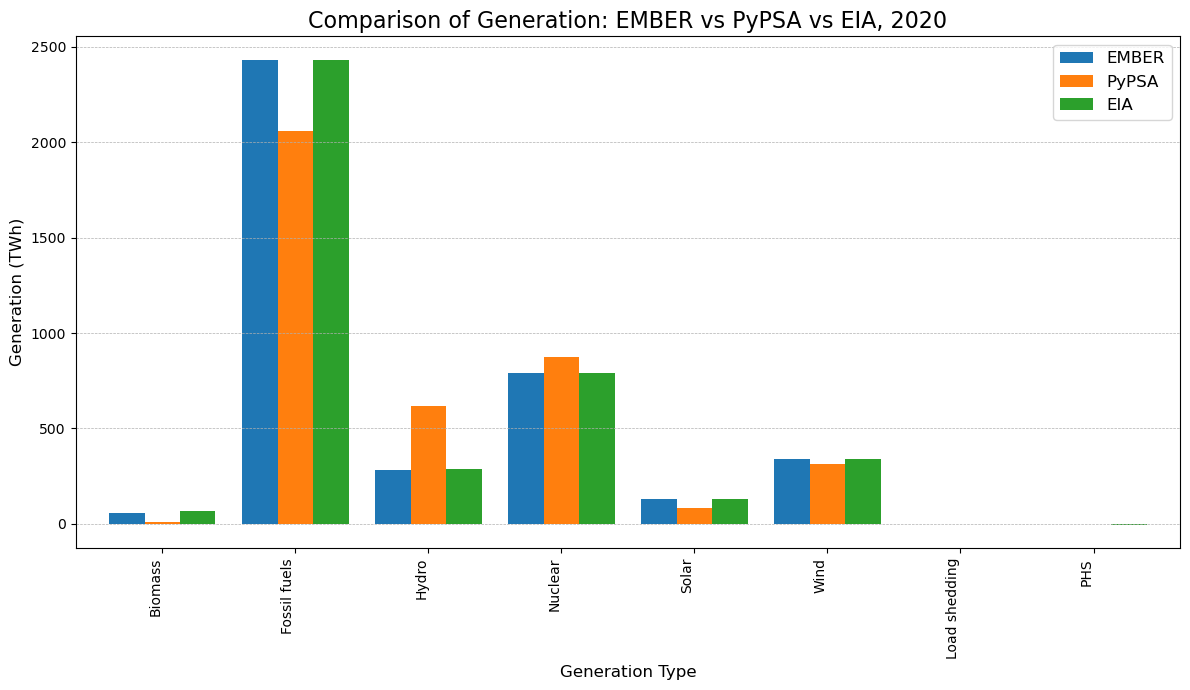

In [17]:
ax = generation_df.plot(kind="bar", figsize=(12, 7), width=0.8)
plt.title(f"Comparison of Generation: EMBER vs PyPSA vs EIA, {year}", fontsize=16)
plt.xlabel("Generation Type", fontsize=12)
plt.ylabel("Generation (TWh)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend(["EMBER", "PyPSA", "EIA"], loc="upper right", fontsize=12)
plt.tight_layout()
plt.savefig(f"../results/generation_validation_ember_{country_code}.png")
plt.show()

#### More Details

##### Extra functionalities

In [18]:
def preprocess_eia_data_generation(data):
    """
    Preprocesses the EIA energy data by renaming and filtering rows and columns.

    Args:
        data (pd.DataFrame): DataFrame containing EIA energy data.

    Returns:
        pd.DataFrame: Cleaned and preprocessed DataFrame ready for analysis.
    """
    
    # Strip the last 13 characters (descriptive text) from the 'country' column
    data["country"] = data["country"].apply(lambda x: x[:-13].strip())
    
    # Set 'country' as the index of the DataFrame
    data.set_index("country", inplace=True)
    
    # Rename columns to provide clarity
    data.columns = ["EIA Data"]
    
    # Rename specific rows to match more standard terms
    data.rename(index={"Hydroelectricity": "Hydro",
                       "Biomass and waste": "Biomass", 
                       "Hydroelectric pumped storage": "PHS"}, inplace=True)
    
    # Drop unwanted renewable energy categories
    data.drop(index=["Fossil fuels", "Renewables", "Non-hydroelectric renewables", 
                                "Geothermal", "Solar, tide, wave, fuel cell", "Tide and wave"], inplace=True)
    
    # Filter the DataFrame to only include relevant energy sources
    data = data.loc[["Nuclear", "Coal", "Natural gas", "Oil", "Hydro", "PHS", "Solar", "Wind", "Biomass", ], :]    
    return data

def get_generation_capacity_pypsa_2(network):
    """
    Get electricity generation by fuel type from the PyPSA network.

    Args:
        network (pypsa.Network): PyPSA network object.

    Returns:
        pd.DataFrame: Electricity generation by fuel type.
    """
    gen_capacities = (network.generators_t
                      .p.multiply(network.snapshot_weightings.objective, axis=0)
                      .groupby(network.generators.carrier, axis=1).sum().sum())
    
    storage_capacities = (network.storage_units_t
                          .p.multiply(network.snapshot_weightings.objective, axis=0)
                          .groupby(network.storage_units.carrier, axis=1).sum().sum())
    
    # Combine generator and storage generation capacities
    generation_pypsa = ((pd.concat([gen_capacities, storage_capacities], axis=0)) / 1e6).round(2)

    # Define all possible carriers
    all_carriers = ["nuclear", "coal", "lignite", "CCGT", "OCGT", 
                    "hydro", "ror", "PHS", "solar", "offwind-ac", 
                    "offwind-dc", "onwind", "biomass", "load"]
    
    # Reindex to include missing carriers
    generation_pypsa = generation_pypsa.reindex(all_carriers, fill_value=0)
    
    # Rename fuel types to match convention
    generation_pypsa.rename(index={
        "nuclear":"Nuclear", 
        "solar":"Solar", 
        "biomass":"Biomass", 
        "load":"Load shedding"}, inplace=True)
    
    # Aggregate fossil fuel, hydro, and wind generation
    generation_pypsa["Natural gas"] = generation_pypsa[["CCGT", "OCGT"]].sum()
    generation_pypsa["Coal"] = generation_pypsa[["coal", "lignite"]].sum()
    generation_pypsa["Hydro"] = generation_pypsa[["hydro", "ror"]].sum()
    generation_pypsa["Wind"] = generation_pypsa[["offwind-ac", "offwind-dc", "onwind"]].sum()
    
    # Adjust load shedding value
    generation_pypsa["Load shedding"] /= 1e3
    
    # Filter and reformat
    generation_pypsa = generation_pypsa.loc[["Nuclear", "Natural gas", "PHS", "Coal",
                                             "Hydro", "Solar", "Wind", "Biomass", 
                                             "Load shedding"]]
    generation_pypsa.name = "PyPSA data"
    generation_pypsa = generation_pypsa.to_frame()
    return generation_pypsa

def get_generation_capacity_ember_2(data, three_country_code, year):
    """
    Get electricity generation by fuel type for a given country and year from Ember data.

    Args:
        data (pd.DataFrame): Ember data.
        three_country_code (str): Country code (ISO 3166-1 alpha-3).
        year (int): Year of interest.

    Returns:
        pd.DataFrame: Electricity generation by fuel type.
    """
    generation_ember = data[
        (data["Category"] == "Electricity generation")
        & (data["Country code"] == three_country_code)
        & (data["Year"] == year)
        & (data["Subcategory"] == "Fuel")
        & (data["Unit"] == "TWh")
            ][["Variable", "Value"]].reset_index(drop=True)

    # Drop irrelevant rows
    drop_row = ["Other Renewables"]
    generation_ember = generation_ember[~generation_ember["Variable"].isin(drop_row)]

    # Standardize fuel types
    generation_ember = generation_ember.replace({
        "Gas": "Natural gas", 
        "Bioenergy": "Biomass", 
        # "Coal": "Fossil fuels",
        # "Other Fossil": "Fossil fuels"
        })
    
    # Group by fuel type
    generation_ember = generation_ember.groupby("Variable").sum()
    generation_ember.loc["Load shedding"] = 0.0
    generation_ember.columns = ["Ember data"]

    return generation_ember

##### Visualization

In [19]:
generation_data_ember_ = get_generation_capacity_ember_2(ember_data, three_country_code, year)
EIA_generation_ = get_data_EIA(EIA_generation_path, country_code, year)
EIA_generation_ = preprocess_eia_data_generation(EIA_generation_)
pypsa_generation_ = get_generation_capacity_pypsa_2(network)

In [20]:
generation_df_ = pd.concat([generation_data_ember_, pypsa_generation_, EIA_generation_], axis=1).fillna(0)
generation_df_

,Ember data,PyPSA data,EIA Data
Biomass,54.70,9.07,67.566802
Coal,773.39,28.39,773.392897
Hydro,279.95,616.19,285.273895
Natural gas,1624.17,2029.50,1626.789640
Nuclear,789.88,875.65,789.878863
Other Fossil,34.34,0.00,0.000000
Solar,130.72,82.54,130.721095
Wind,337.94,312.77,337.938049
Load shedding,0.00,0.00,0.000000
PHS,0.00,0.00,-5.321205


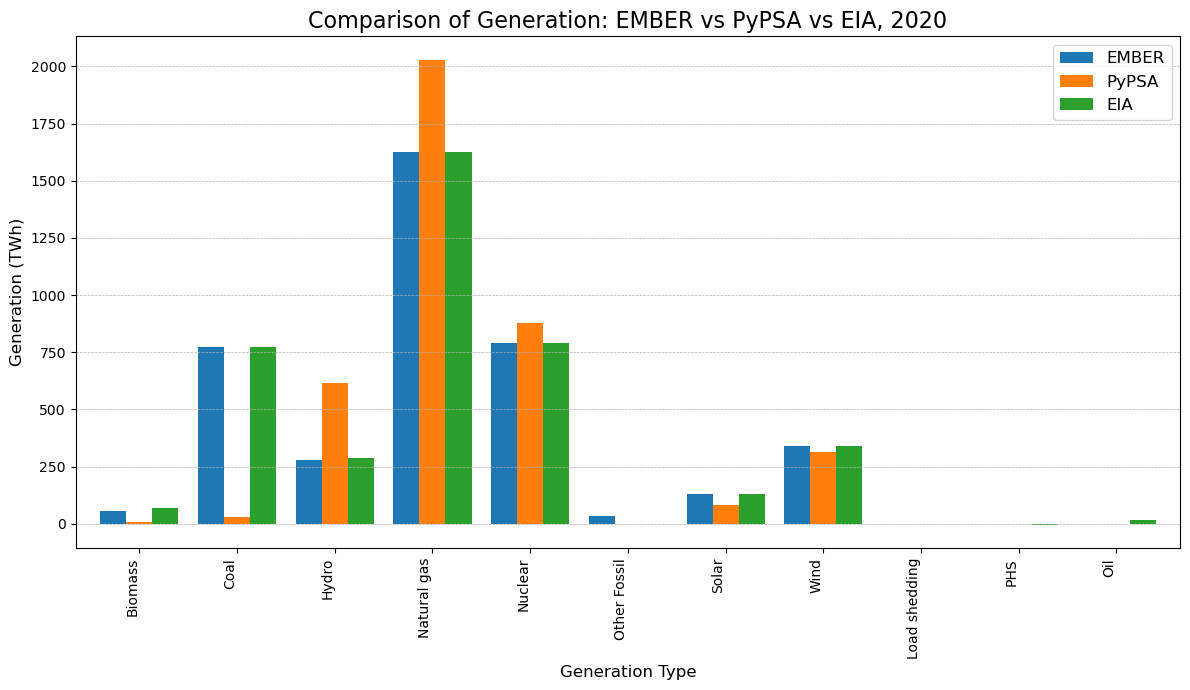

In [21]:
ax = generation_df_.plot(kind="bar", figsize=(12, 7), width=0.8)
plt.title(f"Comparison of Generation: EMBER vs PyPSA vs EIA, {year}", fontsize=16)
plt.xlabel("Generation Type", fontsize=12)
plt.ylabel("Generation (TWh)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend(["EMBER", "PyPSA", "EIA"], loc="upper right", fontsize=12)
plt.tight_layout()
plt.savefig(f"../results/generation_validation_ember_{country_code}_detailed.png")
plt.show()